# MAVIS Astrometric Simulator

## Phase A Version
March 2020

## Todo
1. Update the PSDdatabase

# Imports

In [1]:
# Standard
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Astropy
from astropy.io import fits, ascii
from astropy.table import Table

# Project-specific/
#sys.path.append('/src')
cwd = os.getcwd()
os.chdir(os.getcwd() + "/src")

#import mavisim.rampup
#import mavisim.addconstantsky
import mavisim.addnoise
#import mavissimim.trimimage
import mavisim.input_parameters as input_par
#from mavisim.generate_image import ImageGenerator
from mavisim.generate_image import ImageGenerator
#from rebin import rebin

from mavisim.Source import Source
#from mavissimim.AOGaussGrid import AOGaussGrid
#from mavissimim.SeeingGrid import SeeingGrid
from mavisim.InputCoo import InputCoo

os.chdir(cwd)


# Store the save path and file name

In [2]:
file_name = "mavisim2test_March17VersionIntPos"
image_save_path = cwd + "/TestImages/"
coo_save_path = cwd + "/TestCoordinates/"

print (image_save_path)

/Users/jcranney/MAVISIM/TestImages/


# Load the input data

In [3]:
# Nbody input plus chosen exposure time
ngc3201 = input_par.nbody_in

exp_time = 30

# Experimenting with making the positions integer values
ngc3201["X"] = np.around(ngc3201["X"]/0.00375)*0.00375
ngc3201["Y"] = np.around(ngc3201["Y"]/0.00375)*0.00375

# Experiment with putting a PSF at the centre
#test = ngc3201[0]
#test["X"] = 0.0
#test["Y"] = 0.0
#test["Flux"] = 3880.64117362905

#test_table = Table(names=(["Star", "RA", "Dec", "X", "PM_X", "Y", "PM_Y", "Flux"]),
#                  data = test)

#print (test["Flux"]*exp_time)


# Create the source object (to populate the image)

In [4]:
source = Source(ngc3201[:250], exp_time, tt_amp_fac=1.0, static_dist=False, stat_amp=1.0).main()
#self, mavis_src, exp_time, static_dist, tt_amp_fac, stat_amp

print (source["X"])

No TT kernel applied
No static distortion applied.
         X         
     arcseconds    
-------------------
-12.063749999999999
            0.57375
           -4.51875
          -12.00375
-2.7824999999999998
            4.30125
           -8.04375
            5.42625
             -7.185
           -5.23875
                ...
 6.9712499999999995
           17.61375
-14.591249999999999
              -6.93
             -7.395
              -9.69
            4.77375
            0.25125
              -19.2
0.32999999999999996
Length = 250 rows


# Create the input catalogue to compare with DAOPhot

In [5]:
input_coo = InputCoo(source, trim_cat=True).main()

# Create the Noise-Free Image with E2E PSF

## Initialise TileGenerator object + do FFTs of PSFs

# NOTES to try fixing offset

1. DAOPhot Problem? Try changing the FWHM of the Gaussian, increase the size of the vibration or CD kernel
    1. Jesse's PSFs FWHM on the order 15 mas, before CD (FWHM=6.9 mas) and vibration (FWHM~8 mas) errors
    - At centre of FoV get 15.6 mas
    
    2. Try using PSF at longer wavelength?
    
2. Tiling Problem? Try using existing tiling procedure and then playing with Gaussian offset

3. Is there a correlation with the position of the star in the image

4. Gaussian offset set to 0, set positions to integer pixel positions
    1. Try pre-processing source list, divide by 3.75e-3 round down or up then multiply back


In [8]:
image_gen = ImageGenerator(array_width_pix=12000, pixsize=3.75e-3, source_list=source,
                            psfs_file="src/e2epsfs/e2e_psfs.fits", gauss_width_pix=34)
image_gen.main()
image_final = image_gen.get_rebinned_cropped(rebin_factor=2,cropped_width_as=30.0)

Using varible PSFs
Doing PSF FFTs:
Done.                          
clear   | psf     | prep    | star    | fft     ||  ETA
0.00176 | 0.02279 | 0.00004 | 0.06920 | 0.04411 || 0.14           
done
Totals:
clear   | psf     | prep    | star    | fft     || TOTAL
   0.44 |    5.70 |    0.01 |   17.30 |   11.03 || 34.47


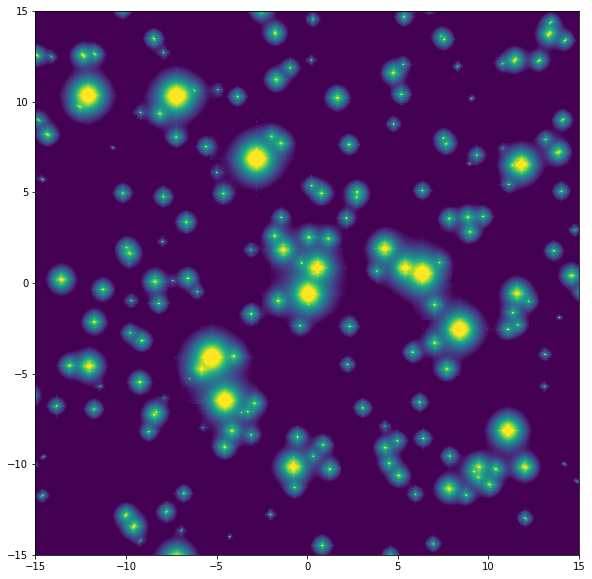

In [15]:
# plot final image:
extent = 30*np.array([-0.5,0.5,-0.5,0.5])
plt.figure(figsize=[10,10])
plt.imshow(np.log(image_final+1), extent=extent)
plt.clim([5,10])

# Add all noise

In [ ]:
# Add sky background, shot noise, read noise and convert from electrons to ADU
image_allnoise = mavisim.addnoise.add_all_noise(image_final, source.meta["exp_time"])

# Save the final image and input catalogue

In [ ]:
image_final_noise = np.array(image_allnoise, dtype="float32")
hdu = fits.PrimaryHDU(image_final_noise)
hdul = fits.HDUList([hdu])
hdul.writeto(image_save_path + file_name + ".fits", overwrite=True)


In [ ]:
ascii.write(input_coo, coo_save_path + file_name + '.all', overwrite=True)

# Experiment with rebinning vs not

In [ ]:
norb_image = fits.open(image_save_path + "mavisim2test_JCFixMarchNoRBBigVibNoNoise.fits")
rb_image = fits.open(image_save_path + "mavisim2test_JCFixMarchRBBigVibNoNoise.fits")

dat_norb = norb_image[0].data
slice_norb = dat_norb[3900:4100, 3900:4100]

dat_rb = rb_image[0].data
slice_rb = dat_rb[1900:2100, 1900:2100]


print (np.where(slice_norb == np.amax(slice_norb)))
print (np.where(slice_rb == np.amax(slice_rb)))


print (np.sum(slice_rb), np.sum(slice_norb), source["Flux"], source["Gauss_Info"][0])
print (np.amax(slice_rb), np.amax(slice_norb))


image = np.array(slice_rb, dtype="float32")
hdu = fits.PrimaryHDU(image)
hdul = fits.HDUList([hdu])
hdul.writeto(image_save_path + "sliceRB.fits", overwrite=True)

image = np.array(slice_norb, dtype="float32")
hdu = fits.PrimaryHDU(image)
hdul = fits.HDUList([hdu])
hdul.writeto(image_save_path + "sliceNoRB.fits", overwrite=True)
